In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import shap
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import re
import string
import warnings
warnings.filterwarnings('ignore')

In [2]:
campaigns = pd.read_csv('campaign_data.csv')
customers = pd.read_csv('customer_demographics.csv')
transactions = pd.read_csv('customer_transaction_data.csv')
coupons = pd.read_csv('coupon_item_mapping.csv')
items = pd.read_csv('item_data.csv')
train = pd.read_csv('train.csv')

In [3]:
campaigns.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,7/9/2013,16/11/13
3,23,Y,8/10/2013,15/11/13
4,21,Y,16/09/13,18/10/13


In [4]:
coupons.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [5]:
transactions.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


How many times, overall, did customers redeem coupons over this period?

In [6]:
campaigns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   campaign_id    28 non-null     int64 
 1   campaign_type  28 non-null     object
 2   start_date     28 non-null     object
 3   end_date       28 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.0+ KB


In [7]:
coupons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92663 entries, 0 to 92662
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   coupon_id  92663 non-null  int64
 1   item_id    92663 non-null  int64
dtypes: int64(2)
memory usage: 1.4 MB


In [8]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   date             1324566 non-null  object 
 1   customer_id      1324566 non-null  int64  
 2   item_id          1324566 non-null  int64  
 3   quantity         1324566 non-null  int64  
 4   selling_price    1324566 non-null  float64
 5   other_discount   1324566 non-null  float64
 6   coupon_discount  1324566 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 70.7+ MB


We want to explore if customers redeemed coupons in the same campaign multiple times. We look at campaign id 13 below and see that customer 1 redeemed 18 coupons, customer 2 19 coupons and so on

In [9]:
train[train['campaign_id']==13].groupby('customer_id').nunique()

,id,campaign_id,coupon_id,customer_id,redemption_status
customer_id,,,,,
1,18,1,18,1,1
3,19,1,19,1,1
5,26,1,26,1,1
7,20,1,20,1,1
8,22,1,22,1,2
...,...,...,...,...,...
1574,34,1,33,1,2
1578,17,1,17,1,1
1579,20,1,20,1,1


Further, we look at how many unique coupon_id's are associated with each campaign in the training set.

In [10]:
train.groupby('campaign_id')['coupon_id'].nunique()

campaign_id
1      11
2      16
3      34
4      12
5      11
6       1
7       8
8     208
9      18
10     14
11     13
12     15
13    207
26    181
27     27
28     28
29     33
30    178
Name: coupon_id, dtype: int64

Similarly, we look at how many unique campaigns are associated with each coupon and see that some coupons have been used for more than one campaign.

In [11]:
coupons_to_campaigns = train.groupby('coupon_id').agg(['unique'])['campaign_id']
print(coupons_to_campaigns.shape)
coupons_to_campaigns

(866, 1)


,unique
coupon_id,
1,[26]
2,[26]
3,[29]
4,[30]
5,[30]
...,...
1108,[13]
1110,"[8, 30]"
1112,"[13, 1]"


In [12]:
coupons_to_campaigns['length'] = coupons_to_campaigns['unique'].str.len()
coupons_to_campaigns[coupons_to_campaigns['length']>1].sort_values(by='length').head()

,unique,length
coupon_id,,
243,"[29, 26]",2
889,"[8, 30]",2
885,"[8, 13]",2
870,"[9, 26]",2
864,"[27, 3]",2


Let's convert the date columns to datetime object

In [13]:
transactions['date'] = pd.to_datetime(transactions['date'], dayfirst=True)
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date             1324566 non-null  datetime64[ns]
 1   customer_id      1324566 non-null  int64         
 2   item_id          1324566 non-null  int64         
 3   quantity         1324566 non-null  int64         
 4   selling_price    1324566 non-null  float64       
 5   other_discount   1324566 non-null  float64       
 6   coupon_discount  1324566 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 70.7 MB


In [14]:
campaigns['start_date'] = pd.to_datetime(campaigns['start_date'], dayfirst=True)
campaigns['end_date'] = pd.to_datetime(campaigns['end_date'], dayfirst=True)

In [15]:
transactions.sort_values(by='date').tail()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
1323113,2013-07-03,208,14759,1,89.05,-6.77,0.0
1323112,2013-07-03,208,13212,1,120.75,0.00,0.0
1323111,2013-07-03,208,11332,1,142.12,0.00,0.0
1323125,2013-07-03,208,30932,1,106.50,0.00,0.0
1322974,2013-07-03,110,9561,4,142.48,-84.06,0.0


We want to investigate if customers can use a coupon discount on the same item multiple times in a single transaction. From our analysis below, it turns out that 533 customers have done that.

In [17]:
transactions_redeemed = transactions[transactions['coupon_discount']!=0]
transactions_redeemed.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
88,2012-01-02,464,5525,1,106.50,-35.62,-35.62
93,2012-01-02,464,8145,1,39.18,-24.58,-14.25
104,2012-01-02,464,16381,1,48.80,-14.96,-35.62
107,2012-01-02,464,17861,3,75.51,-32.06,-26.71
112,2012-01-02,464,19583,2,124.67,-45.59,-35.62


In [18]:
items_unique = []
for customer in transactions_redeemed['customer_id'].unique():
    df_customer = transactions_redeemed[transactions_redeemed['customer_id']==customer]
    for date in df_customer['date'].unique():
        df_date = df_customer[df_customer['date']==date]
        items_unique.append(df_date['item_id'].is_unique)
counter = collections.Counter(items_unique)
print(counter)

Counter({True: 8611, False: 533})


In [19]:
transactions[transactions['coupon_discount']!=0].shape

(21286, 7)

In [20]:
transactions[transactions['coupon_discount'] == 0].shape

(1303280, 7)

We want to group the data by customer, item and transaction date and sum up the column values.

In [21]:
transactions_by_customer = transactions.groupby(['customer_id', 'item_id', 'date']).sum()
transactions_by_customer.head()

quantity  selling_price  other_discount  \
customer_id item_id date                                                  
1           4315    2013-06-20         1         201.97             0.0   
            4577    2012-11-07         2         120.40             0.0   
            4796    2012-10-18         1         106.50             0.0   
            4953    2012-02-21         1         142.12             0.0   
                    2012-05-17         1         142.12             0.0   

                                coupon_discount  
customer_id item_id date                         
1           4315    2013-06-20              0.0  
            4577    2012-11-07              0.0  
            4796    2012-10-18              0.0  
            4953    2012-02-21              0.0  
                    2012-05-17              0.0

Next we merge this with our customer and item data

In [22]:
customers.set_index('customer_id', inplace=True)
items.set_index('item_id', inplace=True)

In [23]:
transactions_by_customer = transactions_by_customer.merge(customers, left_index=True, right_index=True, how='right')
transactions_by_customer.head()

quantity  selling_price  other_discount  \
customer_id item_id date                                                  
1           4315    2013-06-20         1         201.97             0.0   
            4577    2012-11-07         2         120.40             0.0   
            4796    2012-10-18         1         106.50             0.0   
            4953    2012-02-21         1         142.12             0.0   
                    2012-05-17         1         142.12             0.0   

                                coupon_discount age_range marital_status  \
customer_id item_id date                                                   
1           4315    2013-06-20              0.0       70+        Married   
            4577    2012-11-07              0.0       70+        Married   
            4796    2012-10-18              0.0       70+        Married   
            4953    2012-02-21              0.0       70+        Married   
                    2012-05-17              0.0       70+        Married   

                                rented family_size no_of_children  \
customer_id item_id date                                            
1           4315    2013-06-20       0           2            NaN   
            4577    2012-11-07       0           2            NaN   
            4796    2012-10-18       0           2            NaN   
            4953    2012-02-21       0           2            NaN   
                    2012-05-17       0           2            NaN   

                                income_bracket  
customer_id item_id date                        
1           4315    2013-06-20               4  
            4577    2012-11-07               4  
            4796    2012-10-18               4  
            4953    2012-02-21               4  
                    2012-05-17               4

In [24]:
transactions_by_customer = transactions_by_customer.merge(items, how='left',  left_index=True, right_index=True)
transactions_by_customer.head()

quantity  selling_price  other_discount  \
customer_id item_id date                                                  
1           4315    2013-06-20         1         201.97             0.0   
            4577    2012-11-07         2         120.40             0.0   
            4796    2012-10-18         1         106.50             0.0   
            4953    2012-02-21         1         142.12             0.0   
                    2012-05-17         1         142.12             0.0   

                                coupon_discount age_range marital_status  \
customer_id item_id date                                                   
1           4315    2013-06-20              0.0       70+        Married   
            4577    2012-11-07              0.0       70+        Married   
            4796    2012-10-18              0.0       70+        Married   
            4953    2012-02-21              0.0       70+        Married   
                    2012-05-17              0.0       70+        Married   

                                rented family_size no_of_children  \
customer_id item_id date                                            
1           4315    2013-06-20       0           2            NaN   
            4577    2012-11-07       0           2            NaN   
            4796    2012-10-18       0           2            NaN   
            4953    2012-02-21       0           2            NaN   
                    2012-05-17       0           2            NaN   

                                income_bracket  brand   brand_type  \
customer_id item_id date                                             
1           4315    2013-06-20               4   2902  Established   
            4577    2012-11-07               4    115  Established   
            4796    2012-10-18               4    278  Established   
            4953    2012-02-21               4   1061  Established   
                    2012-05-17               4   1061  Established   

                                      category  
customer_id item_id date                        
1           4315    2013-06-20  Pharmaceutical  
            4577    2012-11-07         Grocery  
            4796    2012-10-18         Grocery  
            4953    2012-02-21         Grocery  
                    2012-05-17         Grocery

In [25]:
transactions_by_customer.isnull().sum()

quantity                0
selling_price           0
other_discount          0
coupon_discount         0
age_range               0
marital_status     329215
rented                  0
family_size             0
no_of_children     519855
income_bracket          0
brand                   0
brand_type              0
category                0
dtype: int64

Since they have a lot of null values, We will drop marital_status and no_of_children columns from out dataset later. Now we want to extract information from date into new columns

In [26]:
transactions_by_customer.reset_index(level=2, inplace=True)
transactions_by_customer.head()

date  quantity  selling_price  other_discount  \
customer_id item_id                                                       
1           4315    2013-06-20         1         201.97             0.0   
            4577    2012-11-07         2         120.40             0.0   
            4796    2012-10-18         1         106.50             0.0   
            4953    2012-02-21         1         142.12             0.0   
            4953    2012-05-17         1         142.12             0.0   

                     coupon_discount age_range marital_status  rented  \
customer_id item_id                                                     
1           4315                 0.0       70+        Married       0   
            4577                 0.0       70+        Married       0   
            4796                 0.0       70+        Married       0   
            4953                 0.0       70+        Married       0   
            4953                 0.0       70+        Married       0   

                    family_size no_of_children  income_bracket  brand  \
customer_id item_id                                                     
1           4315              2            NaN               4   2902   
            4577              2            NaN               4    115   
            4796              2            NaN               4    278   
            4953              2            NaN               4   1061   
            4953              2            NaN               4   1061   

                      brand_type        category  
customer_id item_id                               
1           4315     Established  Pharmaceutical  
            4577     Established         Grocery  
            4796     Established         Grocery  
            4953     Established         Grocery  
            4953     Established         Grocery

In [27]:
transactions_by_customer['day'] = transactions_by_customer['date'].dt.day
transactions_by_customer['month'] = transactions_by_customer['date'].dt.month
transactions_by_customer['year'] = transactions_by_customer['date'].dt.year
transactions_by_customer['week'] = transactions_by_customer['date'].dt.week
transactions_by_customer['weekday'] = transactions_by_customer['date'].dt.weekday
transactions_by_customer.head()

date  quantity  selling_price  other_discount  \
customer_id item_id                                                       
1           4315    2013-06-20         1         201.97             0.0   
            4577    2012-11-07         2         120.40             0.0   
            4796    2012-10-18         1         106.50             0.0   
            4953    2012-02-21         1         142.12             0.0   
            4953    2012-05-17         1         142.12             0.0   

                     coupon_discount age_range marital_status  rented  \
customer_id item_id                                                     
1           4315                 0.0       70+        Married       0   
            4577                 0.0       70+        Married       0   
            4796                 0.0       70+        Married       0   
            4953                 0.0       70+        Married       0   
            4953                 0.0       70+        Married       0   

                    family_size no_of_children  income_bracket  brand  \
customer_id item_id                                                     
1           4315              2            NaN               4   2902   
            4577              2            NaN               4    115   
            4796              2            NaN               4    278   
            4953              2            NaN               4   1061   
            4953              2            NaN               4   1061   

                      brand_type        category  day  month  year  week  \
customer_id item_id                                                        
1           4315     Established  Pharmaceutical   20      6  2013    25   
            4577     Established         Grocery    7     11  2012    45   
            4796     Established         Grocery   18     10  2012    42   
            4953     Established         Grocery   21      2  2012     8   
            4953     Established         Grocery   17      5  2012    20   

                     weekday  
customer_id item_id           
1           4315           3  
            4577           2  
            4796           3  
            4953           1  
            4953           3

In [28]:
mymap1 = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
mymap2 = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

transactions_by_customer['weekday'] = transactions_by_customer['weekday'].map(mymap1)
transactions_by_customer['month'] = transactions_by_customer['month'].map(mymap2)

transactions_by_customer.head()

date  quantity  selling_price  other_discount  \
customer_id item_id                                                       
1           4315    2013-06-20         1         201.97             0.0   
            4577    2012-11-07         2         120.40             0.0   
            4796    2012-10-18         1         106.50             0.0   
            4953    2012-02-21         1         142.12             0.0   
            4953    2012-05-17         1         142.12             0.0   

                     coupon_discount age_range marital_status  rented  \
customer_id item_id                                                     
1           4315                 0.0       70+        Married       0   
            4577                 0.0       70+        Married       0   
            4796                 0.0       70+        Married       0   
            4953                 0.0       70+        Married       0   
            4953                 0.0       70+        Married       0   

                    family_size no_of_children  income_bracket  brand  \
customer_id item_id                                                     
1           4315              2            NaN               4   2902   
            4577              2            NaN               4    115   
            4796              2            NaN               4    278   
            4953              2            NaN               4   1061   
            4953              2            NaN               4   1061   

                      brand_type        category  day     month  year  week  \
customer_id item_id                                                           
1           4315     Established  Pharmaceutical   20      June  2013    25   
            4577     Established         Grocery    7  November  2012    45   
            4796     Established         Grocery   18   October  2012    42   
            4953     Established         Grocery   21  February  2012     8   
            4953     Established         Grocery   17       May  2012    20   

                       weekday  
customer_id item_id             
1           4315      Thursday  
            4577     Wednesday  
            4796      Thursday  
            4953       Tuesday  
            4953      Thursday

In [29]:
pd.set_option('display.max_columns', None)
transactions_by_customer.head()

date  quantity  selling_price  other_discount  \
customer_id item_id                                                       
1           4315    2013-06-20         1         201.97             0.0   
            4577    2012-11-07         2         120.40             0.0   
            4796    2012-10-18         1         106.50             0.0   
            4953    2012-02-21         1         142.12             0.0   
            4953    2012-05-17         1         142.12             0.0   

                     coupon_discount age_range marital_status  rented  \
customer_id item_id                                                     
1           4315                 0.0       70+        Married       0   
            4577                 0.0       70+        Married       0   
            4796                 0.0       70+        Married       0   
            4953                 0.0       70+        Married       0   
            4953                 0.0       70+        Married       0   

                    family_size no_of_children  income_bracket  brand  \
customer_id item_id                                                     
1           4315              2            NaN               4   2902   
            4577              2            NaN               4    115   
            4796              2            NaN               4    278   
            4953              2            NaN               4   1061   
            4953              2            NaN               4   1061   

                      brand_type        category  day     month  year  week  \
customer_id item_id                                                           
1           4315     Established  Pharmaceutical   20      June  2013    25   
            4577     Established         Grocery    7  November  2012    45   
            4796     Established         Grocery   18   October  2012    42   
            4953     Established         Grocery   21  February  2012     8   
            4953     Established         Grocery   17       May  2012    20   

                       weekday  
customer_id item_id             
1           4315      Thursday  
            4577     Wednesday  
            4796      Thursday  
            4953       Tuesday  
            4953      Thursday

# Exploratory Data Analysis

## 1. Univariate Analysis

Below, we create count plots of all the discrete variables. This inclused age range, family size, marital status, rented, income bracket, brand type, category, day, month, year, week, weekday

In [30]:
transactions_by_customer['redemption_status'] = 0
transactions_by_customer['redemption_status'][transactions_by_customer['coupon_discount']!=0] = 1
transactions_by_customer.columns

Index(['date', 'quantity', 'selling_price', 'other_discount',
       'coupon_discount', 'age_range', 'marital_status', 'rented',
       'family_size', 'no_of_children', 'income_bracket', 'brand',
       'brand_type', 'category', 'day', 'month', 'year', 'week', 'weekday',
       'redemption_status'],
      dtype='object')

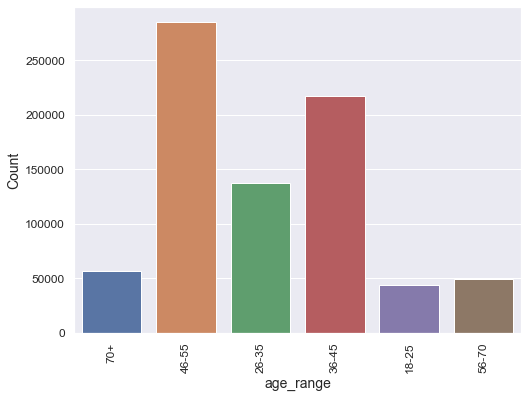

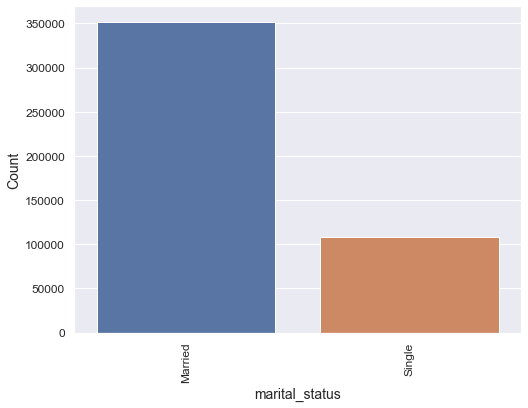

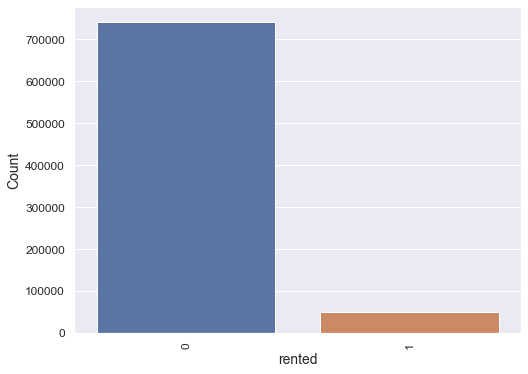

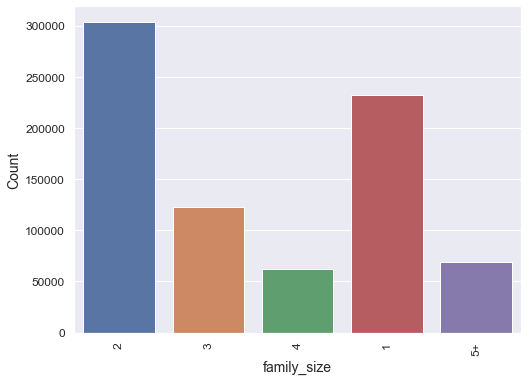

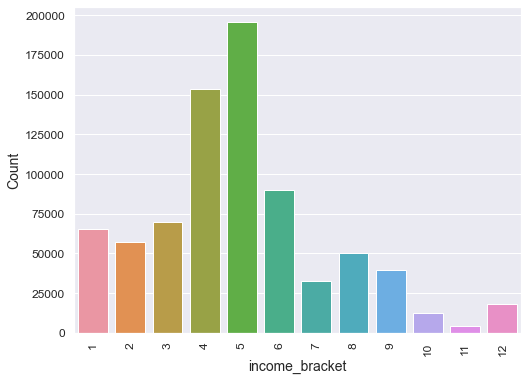

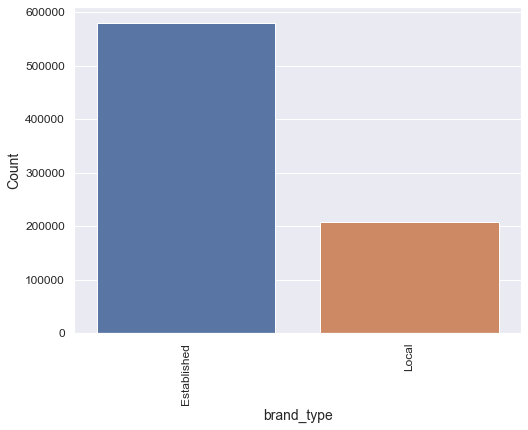

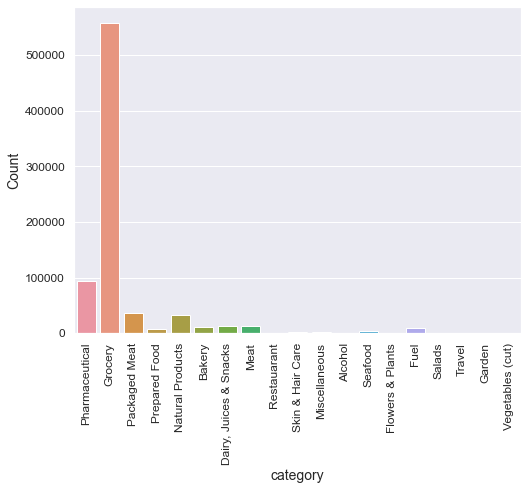

In [31]:
discrete_variables = ['age_range', 'marital_status', 'rented', 'family_size', 'income_bracket', 'brand_type', 'category']

sns.set(rc={'figure.figsize':(8,6)})
for var in discrete_variables:
    sns.countplot(transactions_by_customer[var])
    plt.xticks(fontsize=12, rotation=90)
    plt.yticks(fontsize=12)
    plt.xlabel(var, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.show()

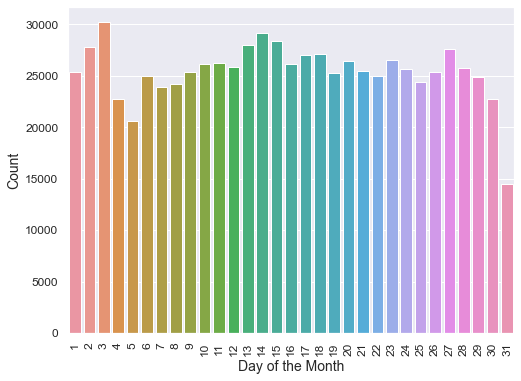

In [32]:
sns.set(rc={'figure.figsize':(8,6)})
sns.countplot(transactions_by_customer['day'])
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.xlabel('Day of the Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

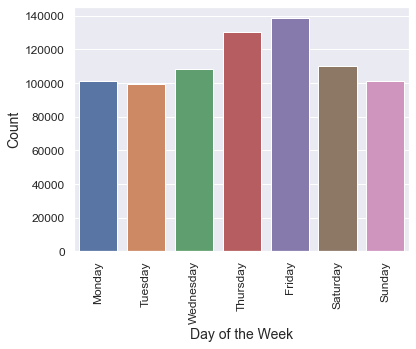

In [33]:
sns.set(rc={'figure.figsize':(6,4.5)})
sns.countplot(transactions_by_customer['weekday'], order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

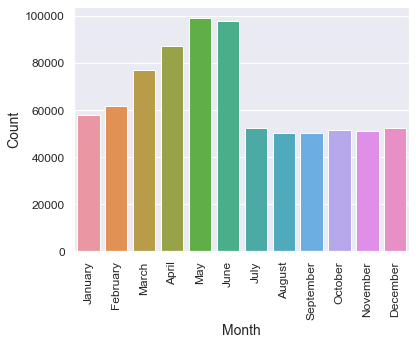

In [34]:
sns.countplot(transactions_by_customer['month'], order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

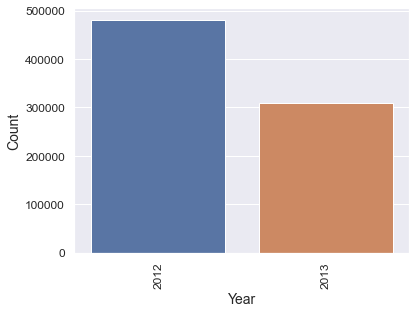

In [35]:
sns.countplot(transactions_by_customer['year'])
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

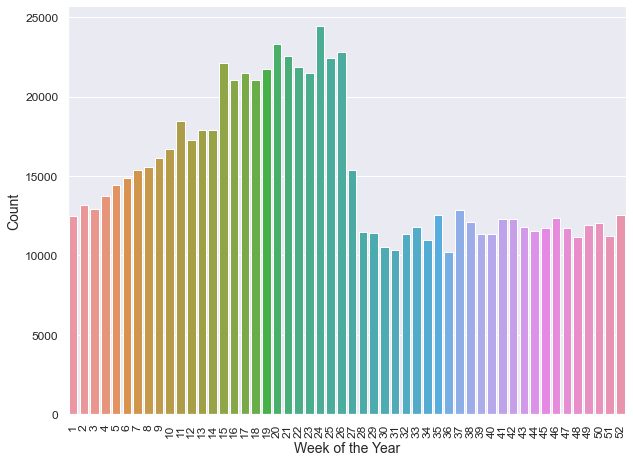

In [36]:
sns.set(rc={'figure.figsize':(10,7.5)})
sns.countplot(transactions_by_customer['week'])
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.xlabel('Week of the Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

Next, we will look at frequency distributions of continuous variables, namely, selling price, other discount, coupon discount

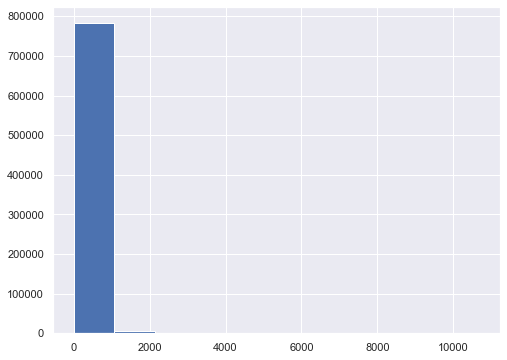

In [37]:
sns.set(rc={'figure.figsize':(8,6)})
transactions_by_customer['selling_price'].hist()

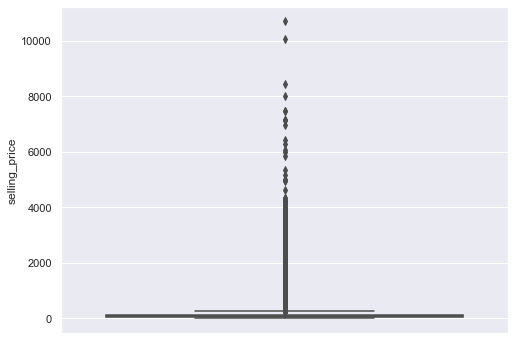

In [38]:
sns.boxplot(data=transactions_by_customer, y='selling_price', hue='redemption_status')

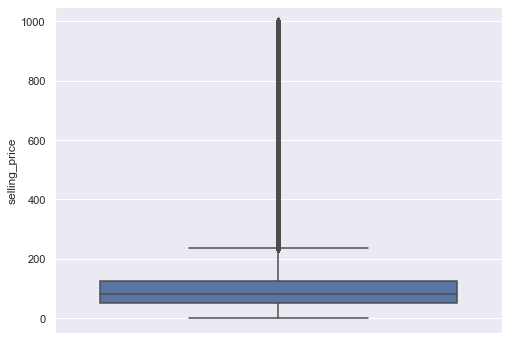

In [39]:
sns.boxplot(data=transactions_by_customer[transactions_by_customer['selling_price']<1000], y='selling_price', hue='redemption_status')

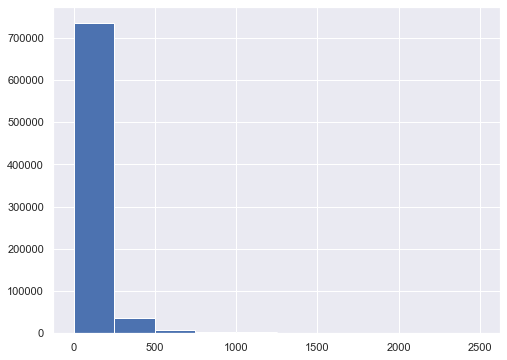

In [40]:
transactions_by_customer['selling_price'][transactions_by_customer['selling_price'] <2500].hist()

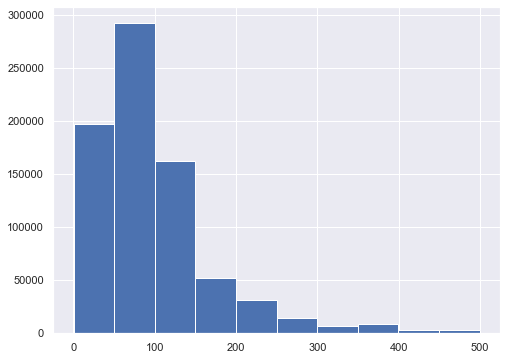

In [41]:
transactions_by_customer['selling_price'][transactions_by_customer['selling_price'] <500].hist()

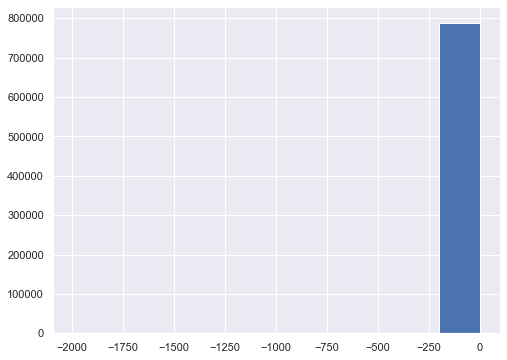

In [42]:
transactions_by_customer['coupon_discount'].hist()

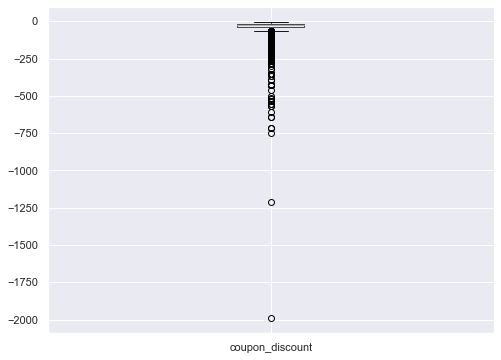

In [43]:
transactions_by_customer[transactions_by_customer['coupon_discount']!=0].boxplot(column='coupon_discount')

In [44]:
transactions_by_customer['coupon_discount'].value_counts()

 0.00      774588
-35.62       3770
-17.81       2463
-19.59       1275
-26.71       1197
            ...  
-163.14         1
-31.70          1
-89.76          1
-236.87         1
-90.83          1
Name: coupon_discount, Length: 209, dtype: int64

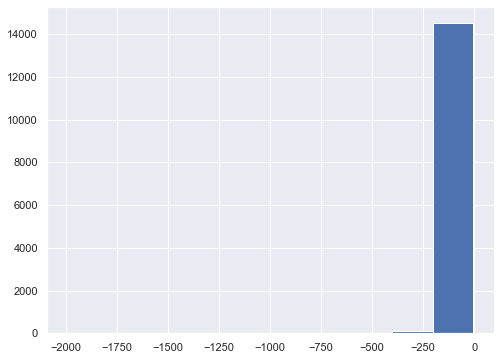

In [45]:
transactions_by_customer['coupon_discount'][transactions_by_customer['coupon_discount'] != 0].hist()

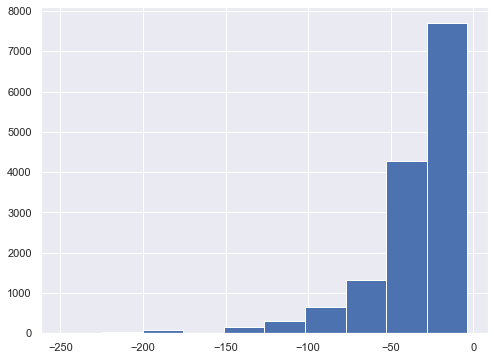

In [46]:
transactions_by_customer['coupon_discount'][(transactions_by_customer['coupon_discount']!=0) & (transactions_by_customer['coupon_discount']>-250)].hist()

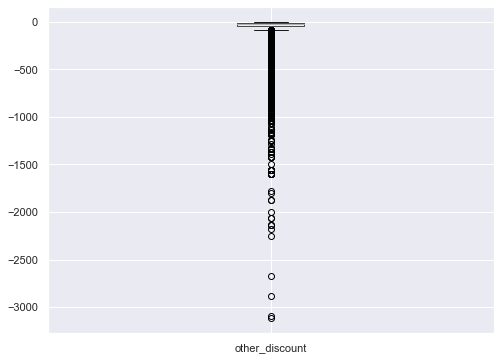

In [47]:
transactions_by_customer[transactions_by_customer['other_discount']!=0].boxplot(column='other_discount')

In [48]:
transactions_by_customer['other_discount'].value_counts()

 0.00      390642
-17.45      20610
-7.12       16253
-35.62      13022
-10.69      12404
            ...  
-371.87         1
-705.28         1
-62.69          1
-483.01         1
-316.31         1
Name: other_discount, Length: 1438, dtype: int64

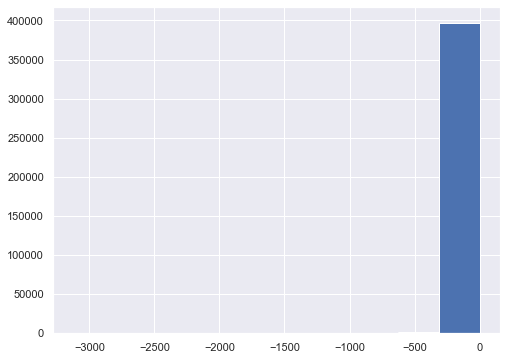

In [49]:
transactions_by_customer['other_discount'][transactions_by_customer['other_discount'] != 0].hist()

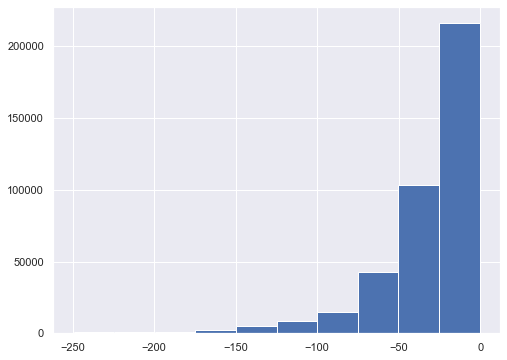

In [50]:
transactions_by_customer['other_discount'][(transactions_by_customer['other_discount']!=0) & (transactions_by_customer['other_discount']>-250)].hist()

## 2. Bivariate Analysis

### Correlation Matrix

In [51]:
categories = transactions_by_customer.columns.tolist()
categories.remove('quantity')
categories.remove('selling_price')
categories.remove('other_discount')
categories.remove('coupon_discount')
categories.remove('redemption_status')


for col in categories:
    transactions_by_customer[col] = transactions_by_customer[col].astype('category')

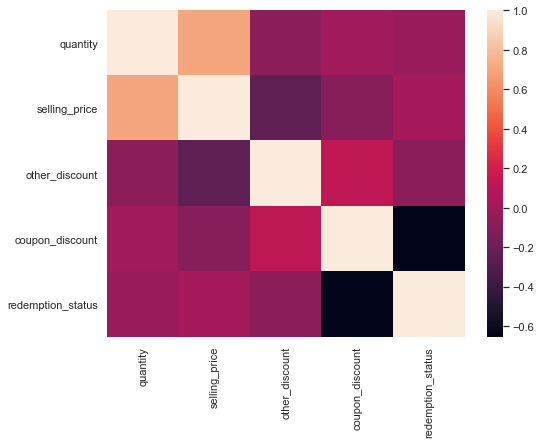

In [52]:
corr_matrix = transactions_by_customer.corr()
sns.heatmap(corr_matrix)

### Pair Plot

Let's add the predicted vairable

In [54]:
#transactions_pp = transactions_by_customer.drop('date', axis=1)
transactions_pp = transactions_by_customer.drop(['date', 'brand', 'quantity', 'no_of_children', 'marital_status', 'year', 'day', 'week'], axis=1)

transactions_pp.columns

Index(['selling_price', 'other_discount', 'coupon_discount', 'age_range',
       'rented', 'family_size', 'income_bracket', 'brand_type', 'category',
       'month', 'weekday', 'redemption_status'],
      dtype='object')

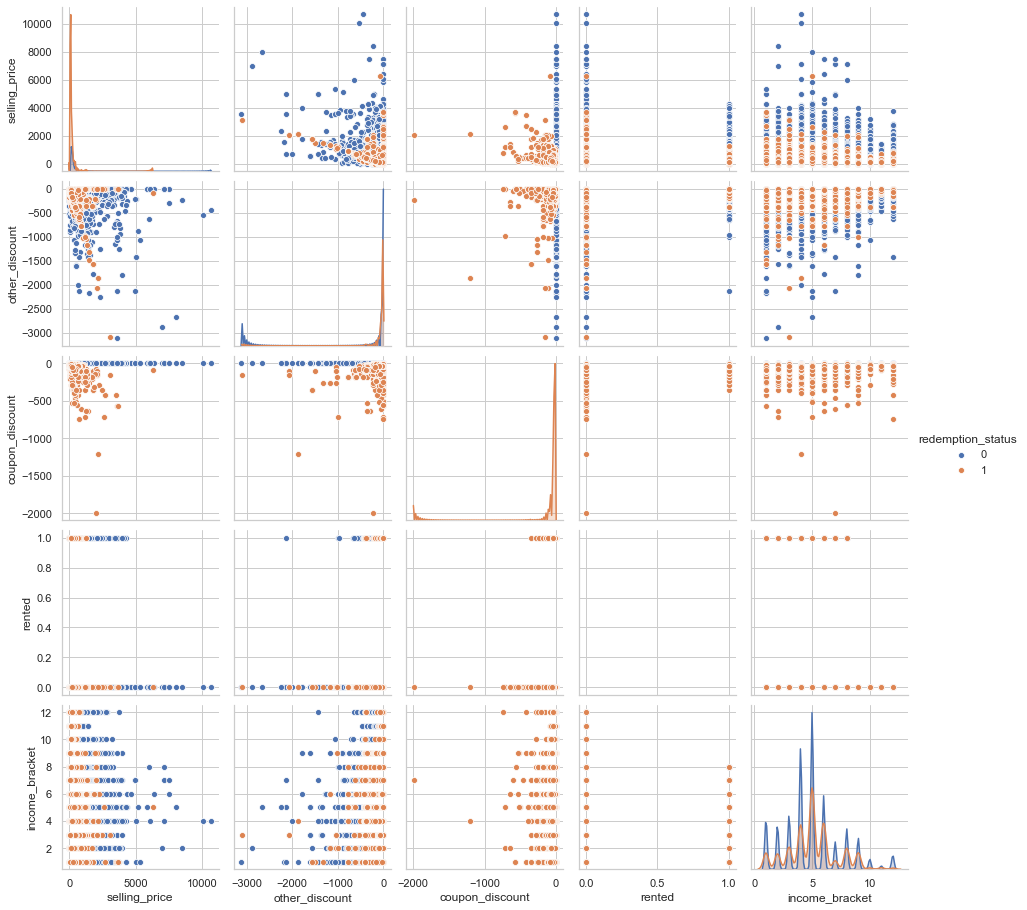

In [55]:
%matplotlib inline
sns.set_style('whitegrid')
sns.pairplot(transactions_pp, hue = 'redemption_status', height=2.5)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.show()

### Numerical vs. Numerical Variables

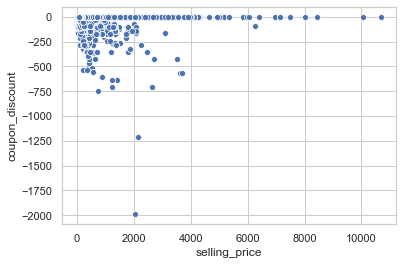

In [56]:
sns.scatterplot(data=transactions_by_customer, x='selling_price', y='coupon_discount')
plt.show()

Most coupon discounts are offered on lower priced items. Most discounts are less than $750.

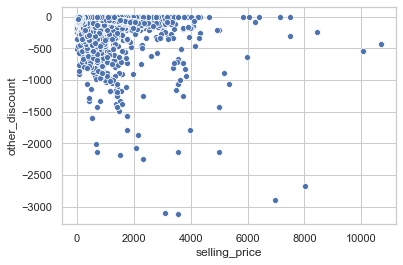

In [57]:
sns.scatterplot(data=transactions_by_customer, x='selling_price', y='other_discount')
plt.show()

Similar to coupons, most other discounts are offered on low price items as weel, with a few exceptions. Some are even offered on items over \\$5000 selling price. Most discounts are less than \\$1500

### Numerical vs. Categorical Variables

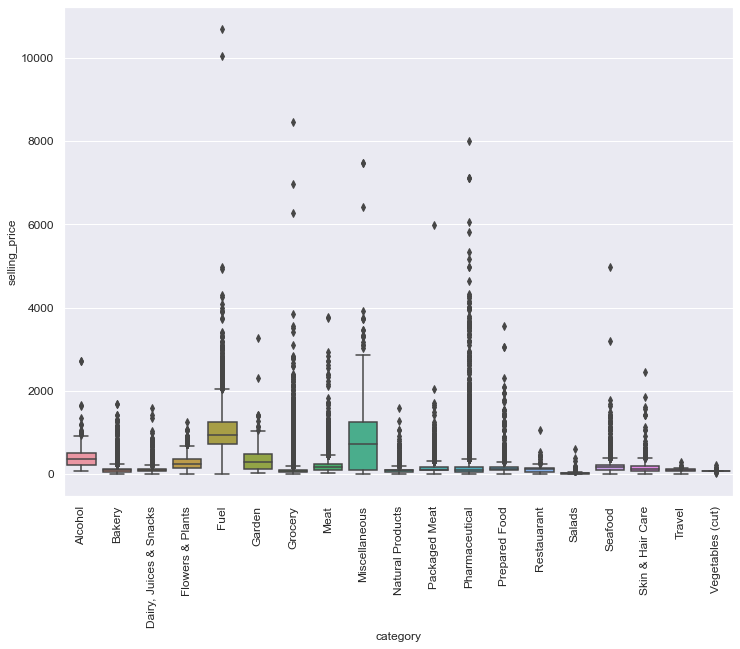

In [58]:
sns.set(rc={'figure.figsize':(12,9)})
sns.boxplot(data=transactions_by_customer, x='category', y='selling_price')
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.show()

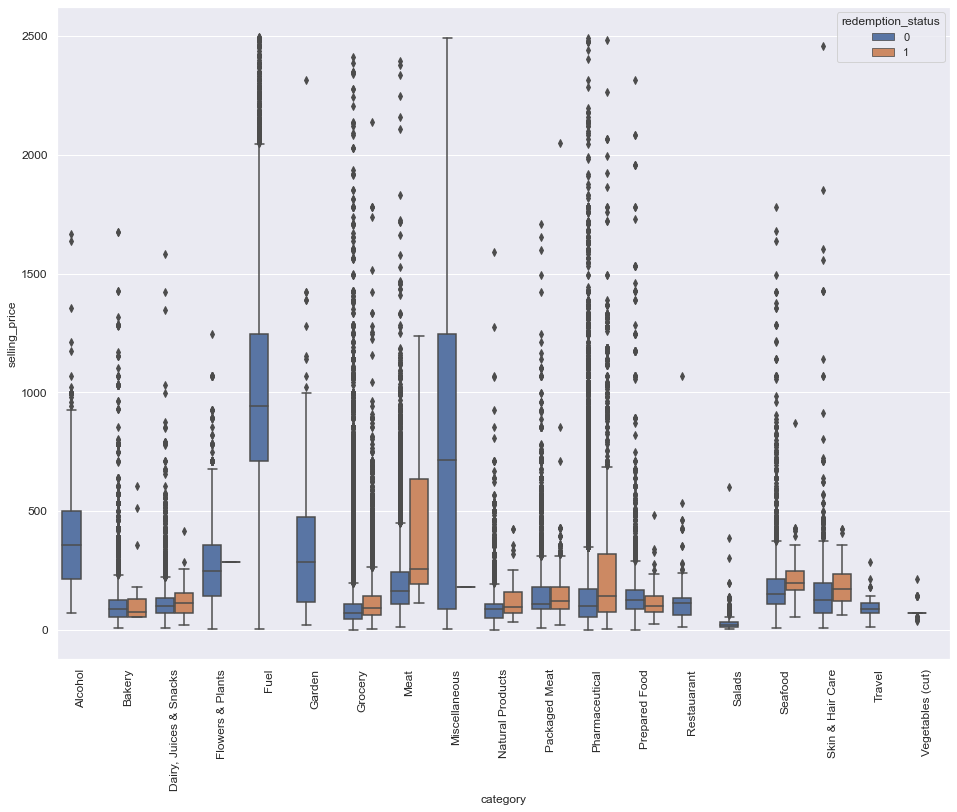

In [59]:
sns.set(rc={'figure.figsize':(16,12)})
sns.boxplot(data=transactions_by_customer[transactions_by_customer['selling_price']<2500], x='category', y='selling_price', hue='redemption_status')
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.show()

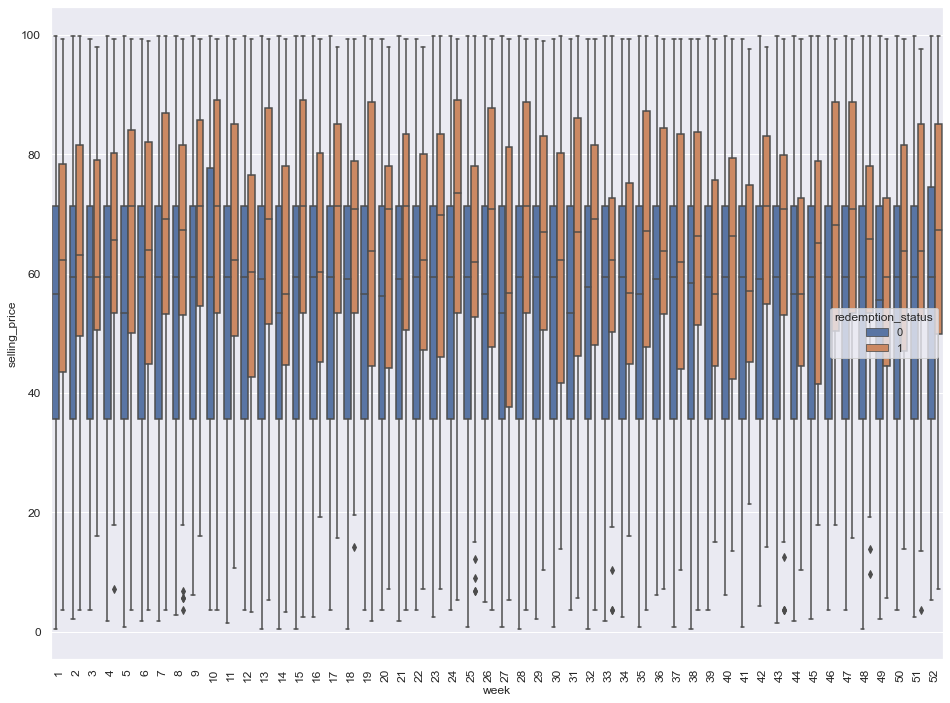

In [60]:
sns.set(rc={'figure.figsize':(16,12)})
sns.boxplot(data=transactions_by_customer[transactions_by_customer['selling_price']<100], x='week', y='selling_price', hue='redemption_status')
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.show()

### Predictor Variable vs. Features

We will now see how the redemption status changes with different features

In [61]:
transactions_by_customer.columns

Index(['date', 'quantity', 'selling_price', 'other_discount',
       'coupon_discount', 'age_range', 'marital_status', 'rented',
       'family_size', 'no_of_children', 'income_bracket', 'brand',
       'brand_type', 'category', 'day', 'month', 'year', 'week', 'weekday',
       'redemption_status'],
      dtype='object')

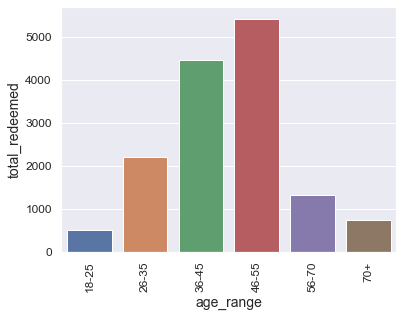

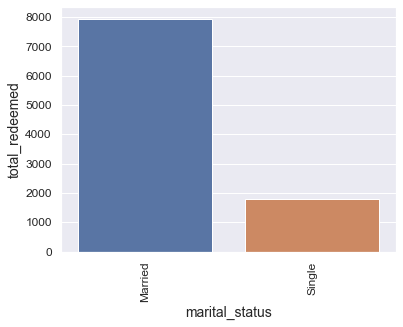

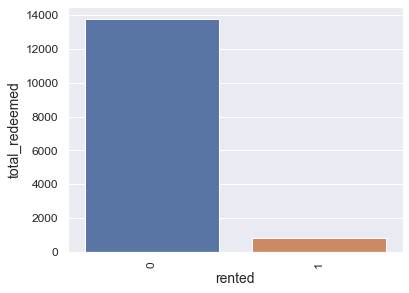

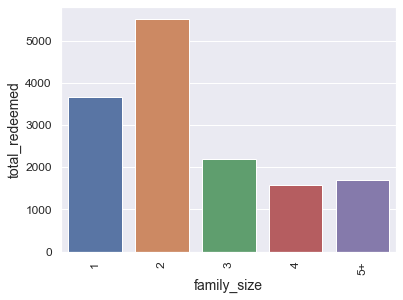

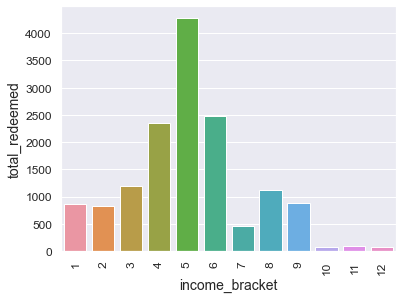

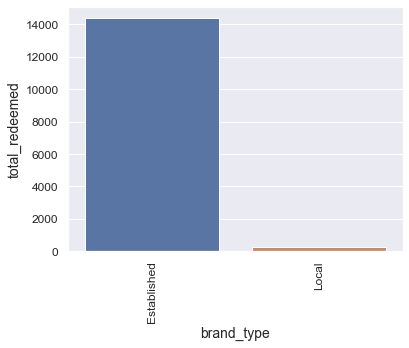

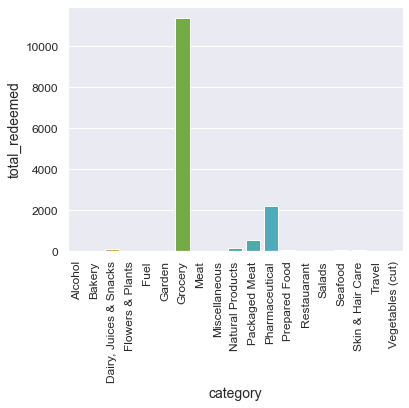

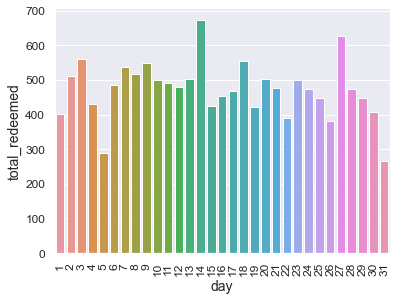

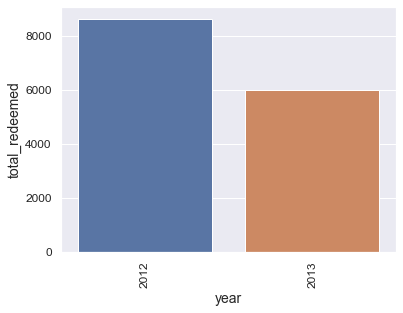

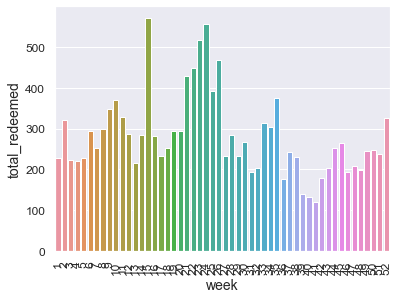

In [62]:
features = ['age_range', 'marital_status', 'rented', 'family_size', 'income_bracket','brand_type', 'category', 'day', 'year', 'week']
sns.set(rc={'figure.figsize':(6, 4.5)})

for feature in features:
    transactions_by_feature = transactions_by_customer.groupby(feature).sum().reset_index()
    sns.barplot(data=transactions_by_feature, x=feature, y='redemption_status')
    plt.xticks(fontsize=12, rotation=90)
    plt.yticks(fontsize=12)
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('total_redeemed', fontsize=14)
    plt.show()

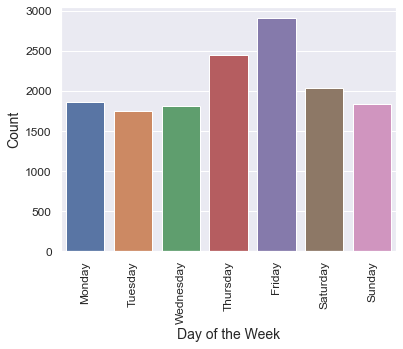

In [63]:
transactions_by_feature = transactions_by_customer.groupby('weekday').sum().reset_index()
sns.barplot(data=transactions_by_feature, y='redemption_status', x='weekday', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

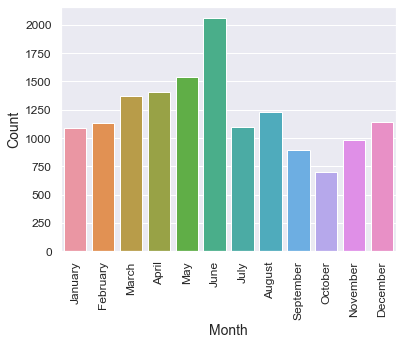

In [64]:
transactions_by_feature = transactions_by_customer.groupby('month').sum().reset_index()
sns.barplot(data=transactions_by_feature, y='redemption_status', x='month', order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

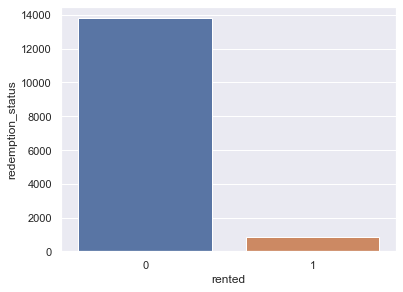

In [65]:
transactions_by_feature = transactions_by_customer.groupby('rented').sum().reset_index()
sns.barplot(data=transactions_by_feature, y='redemption_status', x='rented')

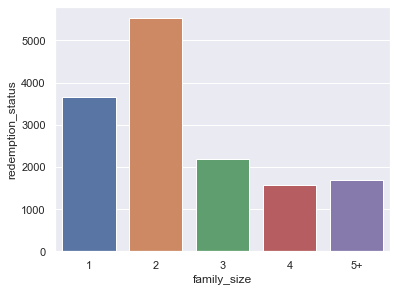

In [66]:
transactions_by_feature = transactions_by_customer.groupby('family_size').sum().reset_index()
sns.barplot(data=transactions_by_feature, y='redemption_status', x='family_size')

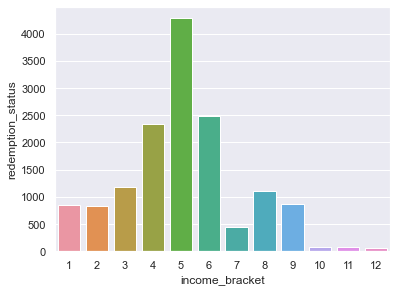

In [67]:
transactions_by_feature = transactions_by_customer.groupby('income_bracket').sum().reset_index()
sns.barplot(data=transactions_by_feature, y='redemption_status', x='income_bracket')

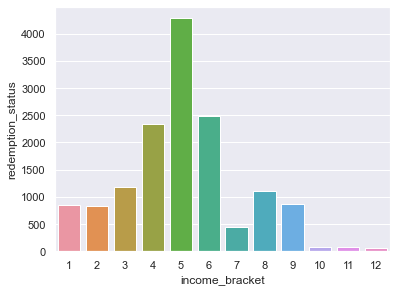

In [68]:
transactions_by_feature = transactions_by_customer.groupby('income_bracket').sum().reset_index()
sns.barplot(data=transactions_by_feature, y='redemption_status', x='income_bracket')

# Feature Engineering

In [69]:
transactions_by_customer['age_range'].value_counts()

46-55    284797
36-45    217249
26-35    137266
70+       56349
56-70     49673
18-25     43893
Name: age_range, dtype: int64

In [70]:
transactions_by_customer['age_range'] = transactions_by_customer['age_range'].astype(str)
le = preprocessing.LabelEncoder()
transactions_by_customer['age_range'] = le.fit_transform(transactions_by_customer['age_range'].values)
transactions_by_customer.head()

date  quantity  selling_price  other_discount  \
customer_id item_id                                                       
1           4315    2013-06-20         1         201.97             0.0   
            4577    2012-11-07         2         120.40             0.0   
            4796    2012-10-18         1         106.50             0.0   
            4953    2012-02-21         1         142.12             0.0   
            4953    2012-05-17         1         142.12             0.0   

                     coupon_discount  age_range marital_status rented  \
customer_id item_id                                                     
1           4315                 0.0          5        Married      0   
            4577                 0.0          5        Married      0   
            4796                 0.0          5        Married      0   
            4953                 0.0          5        Married      0   
            4953                 0.0          5        Married      0   

                    family_size no_of_children income_bracket brand  \
customer_id item_id                                                   
1           4315              2            NaN              4  2902   
            4577              2            NaN              4   115   
            4796              2            NaN              4   278   
            4953              2            NaN              4  1061   
            4953              2            NaN              4  1061   

                      brand_type        category day     month  year week  \
customer_id item_id                                                         
1           4315     Established  Pharmaceutical  20      June  2013   25   
            4577     Established         Grocery   7  November  2012   45   
            4796     Established         Grocery  18   October  2012   42   
            4953     Established         Grocery  21  February  2012    8   
            4953     Established         Grocery  17       May  2012   20   

                       weekday  redemption_status  
customer_id item_id                                
1           4315      Thursday                  0  
            4577     Wednesday                  0  
            4796      Thursday                  0  
            4953       Tuesday                  0  
            4953      Thursday                  0

In [71]:
transactions_by_customer['age_range'].value_counts()

3    284797
2    217249
1    137266
5     56349
4     49673
0     43893
Name: age_range, dtype: int64

In [72]:
transactions_by_customer.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 789227 entries, (1, 4315) to (1581, 73698)
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   date               789227 non-null  category
 1   quantity           789227 non-null  int64   
 2   selling_price      789227 non-null  float64 
 3   other_discount     789227 non-null  float64 
 4   coupon_discount    789227 non-null  float64 
 5   age_range          789227 non-null  int32   
 6   marital_status     460012 non-null  category
 7   rented             789227 non-null  category
 8   family_size        789227 non-null  category
 9   no_of_children     269372 non-null  category
 10  income_bracket     789227 non-null  category
 11  brand              789227 non-null  category
 12  brand_type         789227 non-null  category
 13  category           789227 non-null  category
 14  day                789227 non-null  category
 15  month              

In [73]:
transactions_by_customer['day'] = transactions_by_customer['day'].astype('str')
transactions_by_customer['year'] = transactions_by_customer['year'].astype('str')

transactions_by_customer['marital_status'] = pd.get_dummies(transactions_by_customer['marital_status'], prefix='marital_status')
weekday_ohe = pd.get_dummies(transactions_by_customer['weekday'])
month_ohe = pd.get_dummies(transactions_by_customer['month'])
day_ohe = pd.get_dummies(transactions_by_customer['day'])
year_ohe = pd.get_dummies(transactions_by_customer['year'])
transactions_by_customer = pd.concat([transactions_by_customer, day_ohe, month_ohe, year_ohe, weekday_ohe], axis=1)
transactions_by_customer.head()

date  quantity  selling_price  other_discount  \
customer_id item_id                                                       
1           4315    2013-06-20         1         201.97             0.0   
            4577    2012-11-07         2         120.40             0.0   
            4796    2012-10-18         1         106.50             0.0   
            4953    2012-02-21         1         142.12             0.0   
            4953    2012-05-17         1         142.12             0.0   

                     coupon_discount  age_range  marital_status rented  \
customer_id item_id                                                      
1           4315                 0.0          5               1      0   
            4577                 0.0          5               1      0   
            4796                 0.0          5               1      0   
            4953                 0.0          5               1      0   
            4953                 0.0          5               1      0   

                    family_size no_of_children income_bracket brand  \
customer_id item_id                                                   
1           4315              2            NaN              4  2902   
            4577              2            NaN              4   115   
            4796              2            NaN              4   278   
            4953              2            NaN              4  1061   
            4953              2            NaN              4  1061   

                      brand_type        category day     month  year week  \
customer_id item_id                                                         
1           4315     Established  Pharmaceutical  20      June  2013   25   
            4577     Established         Grocery   7  November  2012   45   
            4796     Established         Grocery  18   October  2012   42   
            4953     Established         Grocery  21  February  2012    8   
            4953     Established         Grocery  17       May  2012   20   

                       weekday  redemption_status  1  10  11  12  13  14  15  \
customer_id item_id                                                            
1           4315      Thursday                  0  0   0   0   0   0   0   0   
            4577     Wednesday                  0  0   0   0   0   0   0   0   
            4796      Thursday                  0  0   0   0   0   0   0   0   
            4953       Tuesday                  0  0   0   0   0   0   0   0   
            4953      Thursday                  0  0   0   0   0   0   0   0   

                     16  17  18  19  2  20  21  22  23  24  25  26  27  28  \
customer_id item_id                                                          
1           4315      0   0   0   0  0   1   0   0   0   0   0   0   0   0   
            4577      0   0   0   0  0   0   0   0   0   0   0   0   0   0   
            4796      0   0   1   0  0   0   0   0   0   0   0   0   0   0   
            4953      0   0   0   0  0   0   1   0   0   0   0   0   0   0   
            4953      0   1   0   0  0   0   0   0   0   0   0   0   0   0   

                     29  3  30  31  4  5  6  7  8  9  April  August  December  \
customer_id item_id                                                             
1           4315      0  0   0   0  0  0  0  0  0  0      0       0         0   
            4577      0  0   0   0  0  0  0  1  0  0      0       0         0   
            4796      0  0   0   0  0  0  0  0  0  0      0       0         0   
            4953      0  0   0   0  0  0  0  0  0  0      0       0         0   
            4953      0  0   0   0  0  0  0  0  0  0      0       0         0   

                     February  January  July  June  March  May  November  \
customer_id item_id                                                        
1           4315            0        0     0     1      0    0         0   
            4577            0        0 

In [75]:
transactions_by_customer.drop(['date', 'weekday', 'month', 'year', 'day'], axis=1, inplace=True)
transactions_by_customer.head()

quantity  selling_price  other_discount  coupon_discount  \
customer_id item_id                                                             
1           4315            1         201.97             0.0              0.0   
            4577            2         120.40             0.0              0.0   
            4796            1         106.50             0.0              0.0   
            4953            1         142.12             0.0              0.0   
            4953            1         142.12             0.0              0.0   

                     age_range  marital_status rented family_size  \
customer_id item_id                                                 
1           4315             5               1      0           2   
            4577             5               1      0           2   
            4796             5               1      0           2   
            4953             5               1      0           2   
            4953             5               1      0           2   

                    no_of_children income_bracket brand   brand_type  \
customer_id item_id                                                    
1           4315               NaN              4  2902  Established   
            4577               NaN              4   115  Established   
            4796               NaN              4   278  Established   
            4953               NaN              4  1061  Established   
            4953               NaN              4  1061  Established   

                           category week  redemption_status  1  10  11  12  \
customer_id item_id                                                          
1           4315     Pharmaceutical   25                  0  0   0   0   0   
            4577            Grocery   45                  0  0   0   0   0   
            4796            Grocery   42                  0  0   0   0   0   
            4953            Grocery    8                  0  0   0   0   0   
            4953            Grocery   20                  0  0   0   0   0   

                     13  14  15  16  17  18  19  2  20  21  22  23  24  25  \
customer_id item_id                                                          
1           4315      0   0   0   0   0   0   0  0   1   0   0   0   0   0   
            4577      0   0   0   0   0   0   0  0   0   0   0   0   0   0   
            4796      0   0   0   0   0   1   0  0   0   0   0   0   0   0   
            4953      0   0   0   0   0   0   0  0   0   1   0   0   0   0   
            4953      0   0   0   0   1   0   0  0   0   0   0   0   0   0   

                     26  27  28  29  3  30  31  4  5  6  7  8  9  April  \
customer_id item_id                                                       
1           4315      0   0   0   0  0   0   0  0  0  0  0  0  0      0   
            4577      0   0   0   0  0   0   0  0  0  0  1  0  0      0   
            4796      0   0   0   0  0   0   0  0  0  0  0  0  0      0   
            4953      0   0   0   0  0   0   0  0  0  0  0  0  0      0   
            4953      0   0   0   0  0   0   0  0  0  0  0  0  0      0   

                     August  December  February  January  July  June  March  \
customer_id item_id                                                           
1           4315          0         0         0        0     0     1      0   
            4577          0         0         0        0     0     0      0   
            4796          0         0         0        0     0     0      0   
            4953          0         0         1        0     0     0      0   
            4953          0         0         0        0     0     0      0   

                     May  November  October  September  2012  2013  Friday  \
customer_id item_id                                                          
1           4315       0         0        0          0     0     1       0   
            4577       0         1        0          0  

In [76]:
transactions_by_customer['brand'].value_counts()

56      205249
487      17571
278      14074
686      12876
1088     12865
         ...  
3752         1
3744         1
3742         1
3739         1
5528         1
Name: brand, Length: 4794, dtype: int64

In [77]:
transactions_by_customer['brand_type'].value_counts()

Established    580619
Local          208608
Name: brand_type, dtype: int64

In [78]:
transactions_by_customer['category'].value_counts()

Grocery                   558555
Pharmaceutical             93734
Packaged Meat              37105
Natural Products           33469
Dairy, Juices & Snacks     13428
Meat                       13221
Bakery                     11437
Fuel                        8637
Prepared Food               8011
Seafood                     4104
Skin & Hair Care            3014
Miscellaneous               1985
Flowers & Plants             997
Alcohol                      694
Garden                       294
Salads                       217
Travel                       131
Restauarant                  129
Vegetables (cut)              65
Name: category, dtype: int64

In [79]:
transactions_by_customer['category'] = transactions_by_customer['category'].str.strip()

map_category = {'Vegetables (cut)':'Grocery', 'Skin & Hair Care': 'Pharmaceutical', 'Packaged Meat':'Meat', 'Seafood':'Meat', \
                'Bakery':'Fresh Food', 'Prepared Food':'Fresh Food', 'Restaurant':'Fresh Food', 'Alcohol':'Miscellaneous', \
                'Fuel':'Miscellaneous', 'Flowers & Plants':'Miscellaneous', 'Garden': 'Miscellaneous', 'Travel':'Miscellaneous', \
                'Grocery':'Grocery', 'Pharmaceutical':'Pharmaceutical', 'Natural Products': 'Natural Products', 'Meat':'Meat', \
                'Dairy, Juices & Snacks':'Dairy & Snacks', 'Miscellaneous':'Miscellaneous', 'Salads':'Grocery'}
transactions_by_customer['category'] = transactions_by_customer['category'].map(map_category)
transactions_by_customer['category'].value_counts()

Grocery             558837
Pharmaceutical       96748
Meat                 54430
Natural Products     33469
Fresh Food           19448
Dairy & Snacks       13428
Miscellaneous        12738
Name: category, dtype: int64

In [80]:
category_ohe = pd.get_dummies(transactions_by_customer['category'])
transactions_by_customer = pd.concat([transactions_by_customer, category_ohe], axis=1)
transactions_by_customer.drop(['category'], axis=1, inplace=True)
transactions_by_customer.head()

quantity  selling_price  other_discount  coupon_discount  \
customer_id item_id                                                             
1           4315            1         201.97             0.0              0.0   
            4577            2         120.40             0.0              0.0   
            4796            1         106.50             0.0              0.0   
            4953            1         142.12             0.0              0.0   
            4953            1         142.12             0.0              0.0   

                     age_range  marital_status rented family_size  \
customer_id item_id                                                 
1           4315             5               1      0           2   
            4577             5               1      0           2   
            4796             5               1      0           2   
            4953             5               1      0           2   
            4953             5               1      0           2   

                    no_of_children income_bracket brand   brand_type week  \
customer_id item_id                                                         
1           4315               NaN              4  2902  Established   25   
            4577               NaN              4   115  Established   45   
            4796               NaN              4   278  Established   42   
            4953               NaN              4  1061  Established    8   
            4953               NaN              4  1061  Established   20   

                     redemption_status  1  10  11  12  13  14  15  16  17  18  \
customer_id item_id                                                             
1           4315                     0  0   0   0   0   0   0   0   0   0   0   
            4577                     0  0   0   0   0   0   0   0   0   0   0   
            4796                     0  0   0   0   0   0   0   0   0   0   1   
            4953                     0  0   0   0   0   0   0   0   0   0   0   
            4953                     0  0   0   0   0   0   0   0   0   1   0   

                     19  2  20  21  22  23  24  25  26  27  28  29  3  30  31  \
customer_id item_id                                                             
1           4315      0  0   1   0   0   0   0   0   0   0   0   0  0   0   0   
            4577      0  0   0   0   0   0   0   0   0   0   0   0  0   0   0   
            4796      0  0   0   0   0   0   0   0   0   0   0   0  0   0   0   
            4953      0  0   0   1   0   0   0   0   0   0   0   0  0   0   0   
            4953      0  0   0   0   0   0   0   0   0   0   0   0  0   0   0   

                     4  5  6  7  8  9  April  August  December  February  \
customer_id item_id                                                        
1           4315     0  0  0  0  0  0      0       0         0         0   
            4577     0  0  0  1  0  0      0       0         0         0   
            4796     0  0  0  0  0  0      0       0         0         0   
            4953     0  0  0  0  0  0      0       0         0         1   
            4953     0  0  0  0  0  0      0       0         0         0   

                     January  July  June  March  May  November  October  \
customer_id item_id                                                       
1           4315           0     0     1      0    0         0        0   
            4577           0     0     0      0    0         1        0   
            4796           0     0     0      0    0         0        1   
            4953           0     0     0      0    0         0        0   
            4953           0     0     0      0    1         0        0   

                     September  2012  2013  Friday  Monday  Saturday  Sunday  \
customer_id item_id                                                            
1           4315             0     0     1       0       0         0      

In [81]:
transactions_by_customer['rented'].value_counts()

0    740868
1     48359
Name: rented, dtype: int64

In [82]:
transactions_by_customer['family_size'].value_counts()

2     303619
1     232279
3     122273
5+     69211
4      61845
Name: family_size, dtype: int64

In [83]:
transactions_by_customer['family_size'] = transactions_by_customer['family_size'].astype(str)
transactions_by_customer['family_size'] = le.fit_transform(transactions_by_customer['family_size'].values)
transactions_by_customer['rented'].value_counts()

0    740868
1     48359
Name: rented, dtype: int64

In [84]:
transactions_by_customer.drop(['no_of_children', 'brand'], axis=1, inplace=True)

In [85]:
transactions_by_customer['income_bracket'].unique()

[4, 5, 3, 6, 1, ..., 8, 9, 12, 10, 11]
Length: 12
Categories (12, int64): [4, 5, 3, 6, ..., 9, 12, 10, 11]

In [86]:
transactions_by_customer['income_bracket'] = transactions_by_customer['income_bracket'].astype(str)
transactions_by_customer['income_bracket'] = le.fit_transform(transactions_by_customer['income_bracket'].values)

In [87]:
transactions_by_customer['brand_type'] = pd.get_dummies(transactions_by_customer['brand_type'])
transactions_by_customer.head()


quantity  selling_price  other_discount  coupon_discount  \
customer_id item_id                                                             
1           4315            1         201.97             0.0              0.0   
            4577            2         120.40             0.0              0.0   
            4796            1         106.50             0.0              0.0   
            4953            1         142.12             0.0              0.0   
            4953            1         142.12             0.0              0.0   

                     age_range  marital_status rented  family_size  \
customer_id item_id                                                  
1           4315             5               1      0            1   
            4577             5               1      0            1   
            4796             5               1      0            1   
            4953             5               1      0            1   
            4953             5               1      0            1   

                     income_bracket  brand_type week  redemption_status  1  \
customer_id item_id                                                          
1           4315                  6           1   25                  0  0   
            4577                  6           1   45                  0  0   
            4796                  6           1   42                  0  0   
            4953                  6           1    8                  0  0   
            4953                  6           1   20                  0  0   

                     10  11  12  13  14  15  16  17  18  19  2  20  21  22  \
customer_id item_id                                                          
1           4315      0   0   0   0   0   0   0   0   0   0  0   1   0   0   
            4577      0   0   0   0   0   0   0   0   0   0  0   0   0   0   
            4796      0   0   0   0   0   0   0   0   1   0  0   0   0   0   
            4953      0   0   0   0   0   0   0   0   0   0  0   0   1   0   
            4953      0   0   0   0   0   0   0   1   0   0  0   0   0   0   

                     23  24  25  26  27  28  29  3  30  31  4  5  6  7  8  9  \
customer_id item_id                                                            
1           4315      0   0   0   0   0   0   0  0   0   0  0  0  0  0  0  0   
            4577      0   0   0   0   0   0   0  0   0   0  0  0  0  1  0  0   
            4796      0   0   0   0   0   0   0  0   0   0  0  0  0  0  0  0   
            4953      0   0   0   0   0   0   0  0   0   0  0  0  0  0  0  0   
            4953      0   0   0   0   0   0   0  0   0   0  0  0  0  0  0  0   

                     April  August  December  February  January  July  June  \
customer_id item_id                                                           
1           4315         0       0         0         0        0     0     1   
            4577         0       0         0         0        0     0     0   
            4796         0       0         0         0        0     0     0   
            4953         0       0         0         1        0     0     0   
            4953         0       0         0         0        0     0     0   

                     March  May  November  October  September  2012  2013  \
customer_id item_id                                                         
1           4315         0    0         0        0          0     0     1   
            4577         0    0         1        0          0     1     0   
            4796         0    0         0        1          0     1     0   
            4953         0    0         0        0          0     1     0   
            4953         0    1         0        0          0     1     0   

                     Friday  Monday  Saturday  Sunday  Thursday  Tuesday  \
customer_id item_id                                                        
1           4315          0       0         0       0        

In [88]:
transactions_by_customer.shape


(789227, 71)

In [89]:
transactions_by_customer = transactions_by_customer.reset_index(drop=True)


In [90]:
transactions_by_customer['redemption_status'] = 0
transactions_by_customer['redemption_status'][transactions_by_customer['coupon_discount']!=0] = 1
transactions_by_customer['redemption_status'].value_counts()

0    774588
1     14639
Name: redemption_status, dtype: int64

In [91]:
transactions_by_customer.head()

,quantity,selling_price,other_discount,coupon_discount,age_range,marital_status,rented,family_size,income_bracket,brand_type,week,redemption_status,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,24,25,26,27,28,29,3,30,31,4,5,6,7,8,9,April,August,December,February,January,July,June,March,May,November,October,September,2012,2013,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Dairy & Snacks,Fresh Food,Grocery,Meat,Miscellaneous,Natural Products,Pharmaceutical
0,1,201.97,0.0,0.0,5,1,0,1,6,1,25,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,2,120.40,0.0,0.0,5,1,0,1,6,1,45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,1,106.50,0.0,0.0,5,1,0,1,6,1,42,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,1,142.12,0.0,0.0,5,1,0,1,6,1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,1,142.12,0.0,0.0,5,1,0,1,6,1,20,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [92]:
transactions_by_customer.columns

Index(['quantity', 'selling_price', 'other_discount', 'coupon_discount',
       'age_range', 'marital_status', 'rented', 'family_size',
       'income_bracket', 'brand_type', 'week', 'redemption_status', '1', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '4',
       '5', '6', '7', '8', '9', 'April', 'August', 'December', 'February',
       'January', 'July', 'June', 'March', 'May', 'November', 'October',
       'September', '2012', '2013', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'Dairy & Snacks', 'Fresh Food',
       'Grocery', 'Meat', 'Miscellaneous', 'Natural Products',
       'Pharmaceutical'],
      dtype='object')

# Modeling

In [93]:
X = transactions_by_customer
X = transactions_by_customer.drop(['quantity', 'redemption_status'], axis=1) #Dependent Variables
X.info()
X['rented'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789227 entries, 0 to 789226
Data columns (total 69 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   selling_price     789227 non-null  float64 
 1   other_discount    789227 non-null  float64 
 2   coupon_discount   789227 non-null  float64 
 3   age_range         789227 non-null  int32   
 4   marital_status    789227 non-null  uint8   
 5   rented            789227 non-null  category
 6   family_size       789227 non-null  int32   
 7   income_bracket    789227 non-null  int32   
 8   brand_type        789227 non-null  uint8   
 9   week              789227 non-null  category
 10  1                 789227 non-null  uint8   
 11  10                789227 non-null  uint8   
 12  11                789227 non-null  uint8   
 13  12                789227 non-null  uint8   
 14  13                789227 non-null  uint8   
 15  14                789227 non-null  uint8   
 16  15

0    740868
1     48359
Name: rented, dtype: int64

In [94]:
X = transactions_by_customer.drop(['quantity', 'redemption_status'], axis=1)

X['rented'] = X['rented'].astype('int')
X['week'] = X['week'].astype('int')

In [95]:
y = transactions_by_customer['redemption_status'] #Target variable
y.head()

0    0
1    0
2    0
3    0
4    0
Name: redemption_status, dtype: int64

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [97]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [98]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [99]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 552458 entries, 453231 to 121958
Data columns (total 69 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   selling_price     552458 non-null  float64
 1   other_discount    552458 non-null  float64
 2   coupon_discount   552458 non-null  float64
 3   age_range         552458 non-null  int32  
 4   marital_status    552458 non-null  uint8  
 5   rented            552458 non-null  int32  
 6   family_size       552458 non-null  int32  
 7   income_bracket    552458 non-null  int32  
 8   brand_type        552458 non-null  uint8  
 9   week              552458 non-null  int32  
 10  1                 552458 non-null  uint8  
 11  10                552458 non-null  uint8  
 12  11                552458 non-null  uint8  
 13  12                552458 non-null  uint8  
 14  13                552458 non-null  uint8  
 15  14                552458 non-null  uint8  
 16  15             

In [100]:
final_iv, IV = data_vars(X_train, y_train)

In [101]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]
X2.head()

,Fresh Food,Grocery,Meat,Miscellaneous,Natural Products,Pharmaceutical,brand_type,family_size,income_bracket,marital_status,other_discount,selling_price
453231,0,1,0,0,0,0,1,1,7,1,-54.50,59.13
733460,0,1,0,0,0,0,0,0,7,0,-14.25,28.14
268099,0,1,0,0,0,0,1,0,6,0,-28.50,70.88
105261,0,1,0,0,0,0,1,1,0,1,0.00,38.83
692746,0,1,0,0,0,0,0,3,7,1,0.00,34.91


In [102]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')

X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Removing Grocery with VIF of 6.183195
Iteration # 2
Complete


In [103]:
X_train=final_df
X_train.head()

,Fresh Food,Meat,Miscellaneous,Natural Products,Pharmaceutical,brand_type,family_size,income_bracket,marital_status,other_discount,selling_price
453231,0,0,0,0,0,1,1,7,1,-54.50,59.13
733460,0,0,0,0,0,0,0,7,0,-14.25,28.14
268099,0,0,0,0,0,1,0,6,0,-28.50,70.88
105261,0,0,0,0,0,1,1,0,1,0.00,38.83
692746,0,0,0,0,0,0,3,7,1,0.00,34.91


In [104]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve




def run_regression_accuracy(X_train, y_train, X_test, y_test):
  logreg = LogisticRegression()
  logreg.fit(X_train, y_train)
  y_pred = logreg.predict(X_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  cm = confusion_matrix(y_test, y_pred)
  print('\nConfusion matrix: \n',cm)

  print('\nClassification report: \n',classification_report(y_test, y_pred))

  logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  
  return logreg

In [105]:
X_test=X_test[X_train.columns]
X_test.head()

,Fresh Food,Meat,Miscellaneous,Natural Products,Pharmaceutical,brand_type,family_size,income_bracket,marital_status,other_discount,selling_price
739466,0,0,0,0,0,1,0,7,0,0.00,57.70
672915,0,0,0,0,0,1,1,7,1,0.00,95.82
181442,0,0,0,0,1,0,2,6,1,0.00,117.19
158044,0,0,0,0,0,1,1,7,0,-24.58,53.43
552425,0,0,0,0,0,0,1,11,1,0.00,14.25


Accuracy of logistic regression classifier on test set: 0.98

Confusion matrix: 
 [[232323     35]
 [  4406      5]]

Classification report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    232358
           1       0.12      0.00      0.00      4411

    accuracy                           0.98    236769
   macro avg       0.55      0.50      0.50    236769
weighted avg       0.97      0.98      0.97    236769



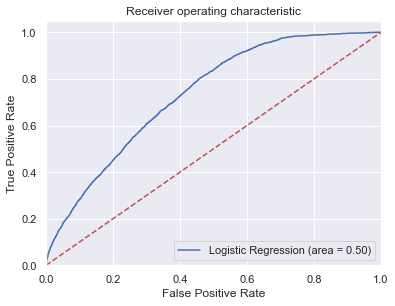

In [106]:
logreg = run_regression_accuracy(X_train, y_train, X_test, y_test)

In [107]:
np.linspace(0.1, 1.0, 10, endpoint=True)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [108]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 10, random_state = 42, max_depth=50, class_weight=dict({1:48, 0:1}), verbose=2)
# Train the model on training data
rf.fit(X_train, y_train)

y_pred1 = rf.predict(X_test)

roc1 = roc_auc_score(y_test, y_pred1)

roc1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


0.6001441903699875

In [109]:
conf1 = confusion_matrix(y_test, y_pred1)
conf1

array([[221110,  11248],
       [  3314,   1097]], dtype=int64)

In [110]:
# Import the model we are using
from sklearn.linear_model import LogisticRegression

# Instantiate model
lr = LogisticRegression(C=1, tol=0.1, multi_class='ovr', class_weight=dict({1:49, 0:1}), solver='newton-cg', max_iter=10, n_jobs=-1, verbose=2)
# Train the model on training data
lr.fit(X_train, y_train)

y_pred2 = lr.predict(X_test)

roc2 = roc_auc_score(y_test, y_pred2)

roc2

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.1s finished


0.6669520074625735

In [111]:
conf2 = confusion_matrix(y_test, y_pred2.round())
conf2

array([[136004,  96354],
       [  1109,   3302]], dtype=int64)

In [112]:
y_train.value_counts()

0    542230
1     10228
Name: redemption_status, dtype: int64

In [113]:
# Import the model we are using
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Instantiate model with 100 decision trees
xgb = XGBClassifier(n_estimators = 10, max_depth=30, max_delta_step=4, scale_pos_weight=49, random_state = 42, verbosity=2, n_jobs=-1, oob_score=True)
# Train the model on training data
xgb.fit(X_train, y_train)

y_pred3 = xgb.predict(X_test)

roc3 = roc_auc_score(y_test, y_pred3)

roc3

[13:14:37] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20618 extra nodes, 0 pruned nodes, max_depth=30
[13:14:38] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20552 extra nodes, 0 pruned nodes, max_depth=30
[13:14:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 19864 extra nodes, 0 pruned nodes, max_depth=30
[13:14:40] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20240 extra nodes, 0 pruned nodes, max_depth=30
[13:14:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20728 extra nodes, 0 pruned nodes, max_depth=30
[13:14:42] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20912 extra nodes, 0 pruned nodes, max_depth=30
[13:14:43] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20858 extra nodes, 0 pruned nodes, max_depth=30
[13:14:45] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20944 extra nodes, 0 pruned nodes, max_depth=30
[13:14:46] INFO: src/tre

0.700449207154442

In [114]:
conf3 = confusion_matrix(y_test, y_pred3)
conf3

array([[209568,  22790],
       [  2210,   2201]], dtype=int64)

# Hyper-parameter Tuning

In [115]:
def algorithm_pipeline(X_train, X_test, y_train, y_test, \
                       model, param_grid, cv=10, scoring_fit='ne_mean_squared_error', do_probabilities=False):
    gs = GridSearchCV(estimator=model, \
                      param_grid=param_grid, \
                      cv=cv, \
                      n_jobs=-1, \
                      scoring=scoring_fit, \
                      verbose=2)
    
    fitted_model = gs.fit(X_train, y_train)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test)
    else:
        pred = fitted_model.predict(X_test)
    return fitted_model, pred

In [116]:
param_grid = {'eta': [0.01, 0.05, 0.1], \
              'max_depth': [9, 10, 11], \
              'scale_pos_weight': [49, 50, 51], \
              'max_delta_step': [4, 6, 8], \
              'grow_policy':['depthwise', 'losswise']}

model = XGBClassifier( n_jobs=-1, random_state = 42, verbosity=2)

In [117]:
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, param_grid, cv=5, scoring_fit='roc_auc')

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 65.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 104.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 179.1min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 197.6min finished


[16:41:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 818 extra nodes, 0 pruned nodes, max_depth=10
[16:41:22] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 770 extra nodes, 0 pruned nodes, max_depth=10
[16:41:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 778 extra nodes, 0 pruned nodes, max_depth=10
[16:41:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 0 pruned nodes, max_depth=10
[16:41:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 808 extra nodes, 0 pruned nodes, max_depth=10
[16:41:23] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 786 extra nodes, 0 pruned nodes, max_depth=10
[16:41:24] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 852 extra nodes, 0 pruned nodes, max_depth=10
[16:41:24] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 846 extra nodes, 0 pruned nodes, max_depth=10
[16:41:24] INFO: src/tree/updater_prune.

[16:41:39] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[16:41:40] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1070 extra nodes, 0 pruned nodes, max_depth=10
[16:41:40] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[16:41:40] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[16:41:40] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 626 extra nodes, 0 pruned nodes, max_depth=10
[16:41:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 722 extra nodes, 0 pruned nodes, max_depth=10
[16:41:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[16:41:41] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 748 extra nodes, 0 pruned nodes, max_depth=10
[16:41:41] INFO: src/tree/updater_prune

In [118]:
print(model.best_score_)
print(model.best_params_)

0.8626256645336305
{'eta': 0.01, 'grow_policy': 'depthwise', 'max_delta_step': 8, 'max_depth': 10, 'scale_pos_weight': 49}


In [120]:
xgb = XGBClassifier(eta=0.01, max_depth=10, scale_pos_weight=49, max_delta_step=8, grow_policy='depthwise', n_jobs=-1, random_state = 42, verbosity=2)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

roc = roc_auc_score(y_test, y_pred)

roc

[17:09:00] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 818 extra nodes, 0 pruned nodes, max_depth=10
[17:09:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 770 extra nodes, 0 pruned nodes, max_depth=10
[17:09:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 778 extra nodes, 0 pruned nodes, max_depth=10
[17:09:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 742 extra nodes, 0 pruned nodes, max_depth=10
[17:09:01] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 808 extra nodes, 0 pruned nodes, max_depth=10
[17:09:02] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 786 extra nodes, 0 pruned nodes, max_depth=10
[17:09:02] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 852 extra nodes, 0 pruned nodes, max_depth=10
[17:09:02] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 846 extra nodes, 0 pruned nodes, max_depth=10
[17:09:02] INFO: src/tree/updater_prune.

[17:09:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[17:09:18] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1070 extra nodes, 0 pruned nodes, max_depth=10
[17:09:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 0 pruned nodes, max_depth=10
[17:09:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 0 pruned nodes, max_depth=10
[17:09:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 626 extra nodes, 0 pruned nodes, max_depth=10
[17:09:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 722 extra nodes, 0 pruned nodes, max_depth=10
[17:09:19] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 390 extra nodes, 0 pruned nodes, max_depth=10
[17:09:20] INFO: src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 748 extra nodes, 0 pruned nodes, max_depth=10
[17:09:20] INFO: src/tree/updater_prune

0.780693728908839

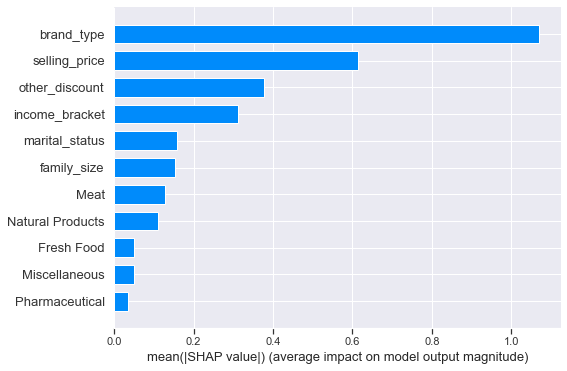

In [122]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

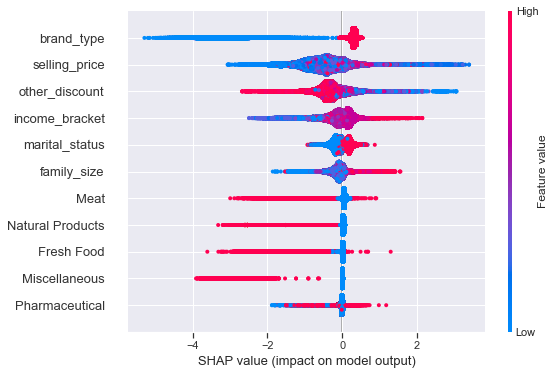

In [123]:
shap.summary_plot(shap_values, X_train)